# Привлекательность и уровень заработной платы
## Постановка задачи
По 1260 опрошенным имеются следующие данные:

* `wage` - заработная плата за час работы, $;
* `exper` - опыт работы, лет;
* `educ` - образование, лет;
* `looks` - внешняя привлекательность, в баллах от 1 до 5;
* бинарные признаки: 
    * `female` - пол, 
    * `married` - семейное положение, 
    * `goodhlth` - состояние здоровья (хорошее/плохое), 
    * `union` - членство в профсоюзе, 
    * `black` - цвет кожи (белый/чёрный), 
    * `service` - занятость в сфере обслуживания (да/нет).

Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.


## Импорты и загрузка данных

In [100]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import scipy.stats as st
import seaborn as sns

In [101]:
data = pd.read_csv('./beauty.csv', delimiter=';')
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


In [102]:
data.columns

Index(['wage ', 'exper', 'union', 'goodhlth', 'black', 'female', 'married',
       'service', 'educ', 'looks'],
      dtype='object')

In [103]:
new_cols = list(data.columns)
new_cols[0] = 'wage'
data.rename(columns=dict(zip(data.columns, new_cols)), inplace=True)
data.columns

Index(['wage', 'exper', 'union', 'goodhlth', 'black', 'female', 'married',
       'service', 'educ', 'looks'],
      dtype='object')

Попарные диаграммы рассеяния всех количественных признаков: 

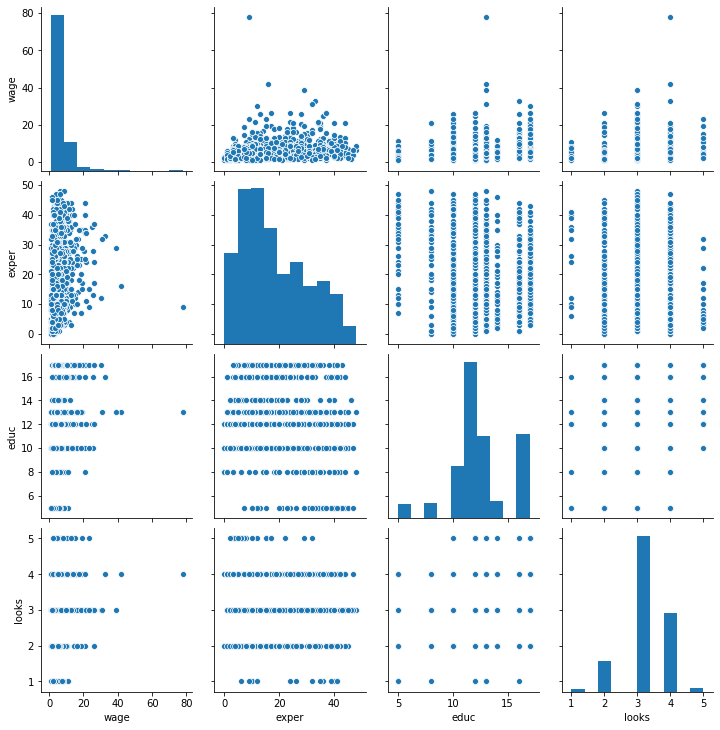

In [104]:
sns.pairplot(data[['wage', 'exper', 'educ', 'looks']])

## Предобработка

Посмотрим на распределение оценок привлекательности: 

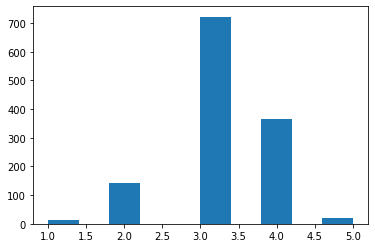

In [105]:
_ = plt.hist(data['looks'])

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:



In [106]:
data['below_avg'] = data['looks'].apply(lambda x: 1 if x < 3 else 0)
data['above_avg'] = data['looks'].apply(lambda x: 1 if x > 3 else 0)
looks = data.looks.copy()
data.drop(columns='looks', inplace=True)

data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,below_avg,above_avg
0,5.73,30,0,1,0,1,1,1,14,0,1
1,4.28,28,0,1,0,1,1,0,12,0,0
2,7.96,35,0,1,0,1,0,0,10,0,1
3,11.57,38,0,1,0,0,1,1,16,0,0
4,11.42,27,0,1,0,0,1,0,16,0,0


Распределение значений отклика:

Text(0.5, 0, 'Log wage')

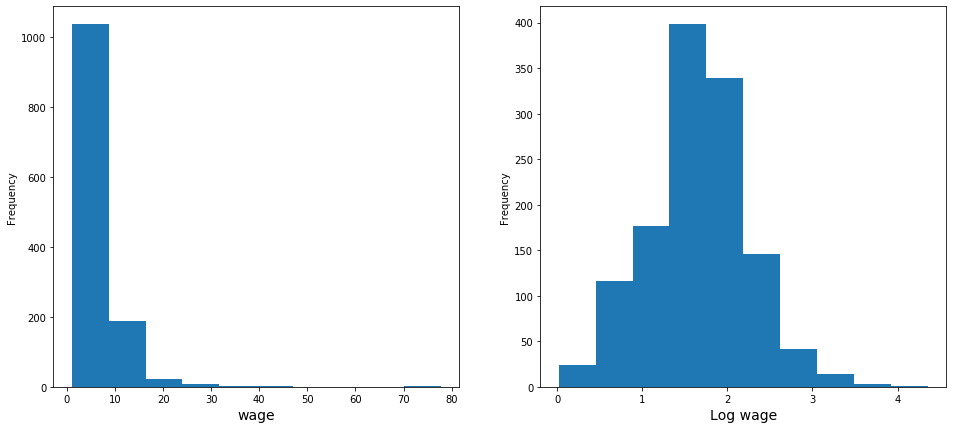

In [107]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
data['wage'].plot.hist()
plt.xlabel('wage', fontsize=14)

plt.subplot(122)
np.log(data['wage']).plot.hist()
plt.xlabel('Log wage', fontsize=14)

Уберем выброс

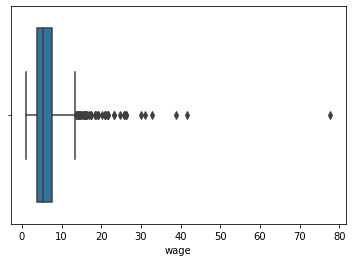

In [108]:
sns.boxplot(data['wage'])

In [109]:
data = data[data['wage'] < 70]

## Модель 0

Просто построим линейную регрессию зарплаты от всех признаков

In [111]:
feat_names = [f for f in data.columns if f not in ['wage']]
features = data[feat_names]
formula0 = ' '.join(['wage ~', 
                    ' + '.join([f for f in feat_names])])
formula0

'wage ~ exper + union + goodhlth + black + female + married + service + educ + below_avg + above_avg'

In [112]:
import statsmodels.api as sm
model0 = sm.OLS.from_formula(formula0, data).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.42e-75
Time:                        19:10:48   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5898      0.743     -0.793      0.428      -2.048       0.869
exper          0.0850      0.009      9.118      0.000       0.067       0.103
union          0.4786      0.234      2.048      0.041       0.020       0.937
goodhlth      -0.0444      0.417     -0.107      0.915      -0.862       0.773
black         -0.6748      0.403     -1.674      0.094      -1.466       0.116
female        -2.3058      0.242     -9.522      0.000      -2.781      -1.831
married        0.4569      0.240      1.905      0.057      -0.014       0.927
service       -0.7303      0.252     -2.896      0.004      -1.225      -0.236
educ           0.4820      0.043     11.272      0.000       0.398       0.566
below_avg     -0.8185      0.323     -2.532      0.011      -1.453      -0.184
above_avg     -0.0729      0.234     -0.311      0.756      -0.532       0.387
==============================================================================
Omnibus:                      898.031   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17969.693
Skew:                           3.076   Prob(JB):                         0.00
Kurtosis:                      20.456   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Проанализируем ошибки

Text(0.5, 0, 'Residuals')

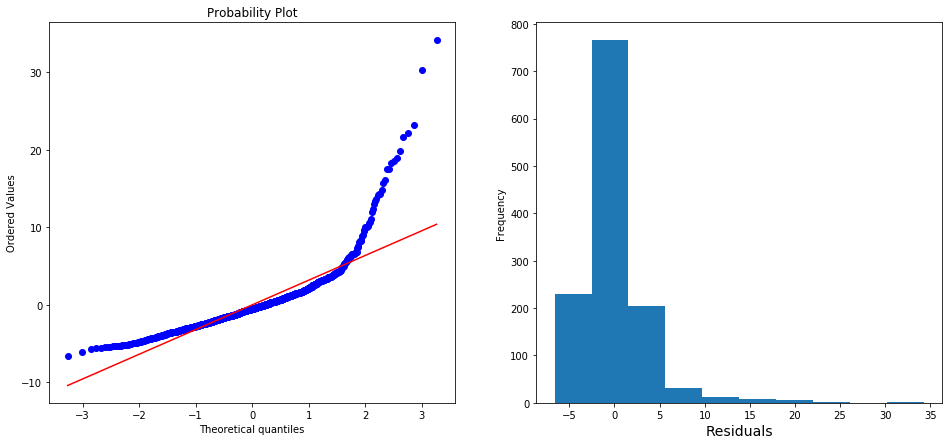

In [113]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
st.probplot(model0.resid, plot=plt)

plt.subplot(122)
model0.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)

Можем воспользоваться преобразованием Бокса-Кокса?

In [114]:
max(data['wage']) / min(data['wage'])

40.85294117647059

$\frac{max y}{min y} \approx 40>10$, поэтому да.

Возьмём $λ=0$, то есть, будем строить регрессию логарифма отклика.

In [115]:
log_wage = st.boxcox(data['wage'], 0)
old_columns = list(data.columns)
data1 = data.copy()
data1['log_wage'] = log_wage

Text(0.5, 0, 'Log wage')

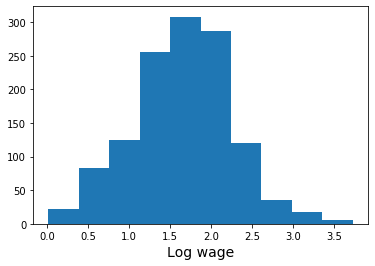

In [116]:
plt.hist(log_wage)
plt.xlabel('Log wage', fontsize=14)

## Модель 1

Построим линейную модель зависимости логарифма заработка по всем признакам. Проверим остатки на нормальность.

In [117]:
features = data1[feat_names]
formula1 = ' '.join(['log_wage ~', 
                    ' + '.join([f for f in feat_names])])
print(formula1)

log_wage ~ exper + union + goodhlth + black + female + married + service + educ + below_avg + above_avg


In [118]:
model1 = sm.OLS.from_formula(formula1, data1).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          1.18e-123
Time:                        19:13:20   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.000       0.265       0.639
exper          0.0138      0.001     11.546      0.000       0.011       0.016
union          0.1785      0.030      5.957      0.000       0.120       0.237
goodhlth       0.0785      0.053      1.470      0.142      -0.026       0.183
black         -0.0989      0.052     -1.913      0.056      -0.200       0.003
female        -0.3938      0.031    -12.684      0.000      -0.455      -0.333
married        0.0425      0.031      1.383      0.167      -0.018       0.103
service       -0.1505      0.032     -4.656      0.000      -0.214      -0.087
educ           0.0799      0.005     14.581      0.000       0.069       0.091
below_avg     -0.1305      0.041     -3.148      0.002      -0.212      -0.049
above_avg     -0.0041      0.030     -0.138      0.890      -0.063       0.055
==============================================================================
Omnibus:                       27.318   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.550
Skew:                           0.159   Prob(JB):                     7.80e-11
Kurtosis:                       3.887   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

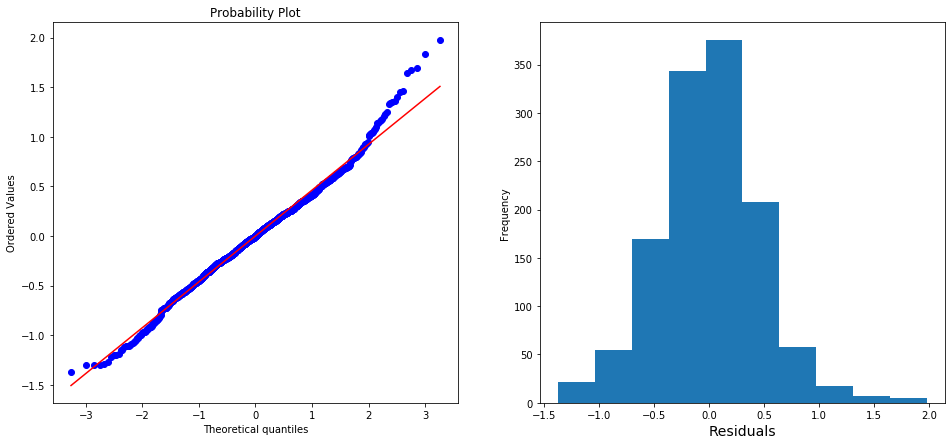

In [119]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
st.probplot(model1.resid, plot=plt)

plt.subplot(122)
model1.resid.plot.hist()
_ = plt.xlabel('Residuals', fontsize=14)

Больше похоже на нормальное

### Проверка гипотез по остаткам

In [120]:
from statsmodels.stats.diagnostic import het_breuschpagan
print(f'Нормальность ошибок: {st.shapiro(model1.resid)}')
print(f'Равенство распределений: {st.wilcoxon(model1.resid)}')
print(f'Гомоскедастичность: {het_breuschpagan(model1.resid, features)}')

Нормальность ошибок: (0.9912799000740051, 8.536291034033638e-07)
Равенство распределений: WilcoxonResult(statistic=395640.0, pvalue=0.9416182399295813)
Гомоскедастичность: (330.28970216940684, 9.65231645842116e-66, 44.419862574285716, 9.275385503769769e-76)


### Рассмотрим зависимость от опыта и образования (самое очевидное)

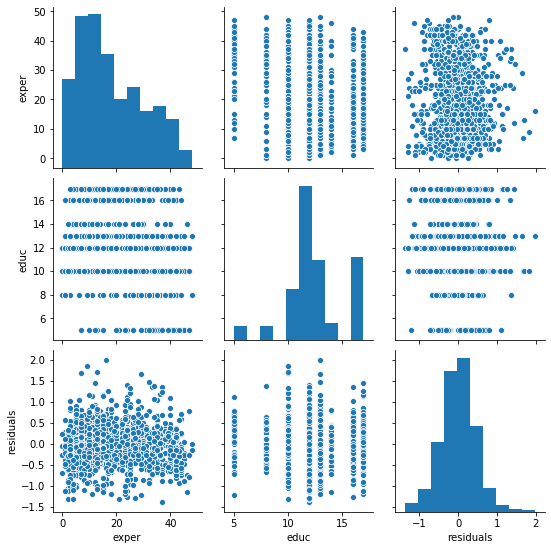

In [121]:
_ = sns.pairplot(pd.DataFrame({
    'exper': features['exper'], 
    'educ': features['educ'], 
    'residuals': model1.resid
}))

Есть ощущение, что `exper` распределены квадратично.

Взглянем более подробно:

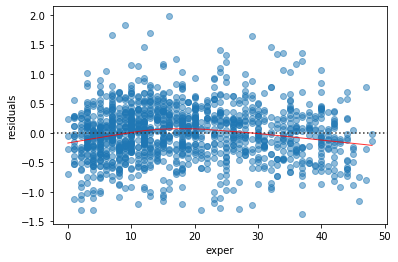

In [122]:
sns.residplot(features['exper'], 
              model1.resid,
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
_ = plt.ylabel('residuals')

## Модель 2

Добавим в модель 1 квадрат опыта работы.

In [123]:
exper2 = features['exper']**2
old_columns = list(data1.columns)
data2 = data1.copy()
data2['exper2'] = exper2
data2.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,below_avg,above_avg,log_wage,exper2
0,5.73,30,0,1,0,1,1,1,14,0,1,1.745716,900
1,4.28,28,0,1,0,1,1,0,12,0,0,1.453953,784
2,7.96,35,0,1,0,1,0,0,10,0,1,2.074429,1225
3,11.57,38,0,1,0,0,1,1,16,0,0,2.448416,1444
4,11.42,27,0,1,0,0,1,0,16,0,0,2.435366,729


In [124]:
feat_names += ['exper2']

In [125]:
features = data2[feat_names]
formula2 = ' '.join(['log_wage ~', 
                    ' + '.join([f for f in feat_names])])
print(formula2)

log_wage ~ exper + union + goodhlth + black + female + married + service + educ + below_avg + above_avg + exper2


In [127]:
model2 = sm.OLS.from_formula(formula2, data2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          3.19e-131
Time:                        19:20:23   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3424      0.095      3.588      0.000       0.155       0.530
exper          0.0404      0.004      9.290      0.000       0.032       0.049
union          0.1710      0.030      5.793      0.000       0.113       0.229
goodhlth       0.0716      0.053      1.361      0.174      -0.032       0.175
black         -0.0831      0.051     -1.631      0.103      -0.183       0.017
female        -0.3936      0.031    -12.875      0.000      -0.454      -0.334
married        0.0101      0.031      0.329      0.742      -0.050       0.070
service       -0.1599      0.032     -5.018      0.000      -0.222      -0.097
educ           0.0758      0.005     13.941      0.000       0.065       0.086
below_avg     -0.1352      0.041     -3.313      0.001      -0.215      -0.055
above_avg     -0.0025      0.030     -0.084      0.933      -0.061       0.056
exper2        -0.0006   9.63e-05     -6.351      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.257
Skew:                           0.140   Prob(JB):                     6.08e-13
Kurtosis:                       3.997   Cond. No.                     5.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

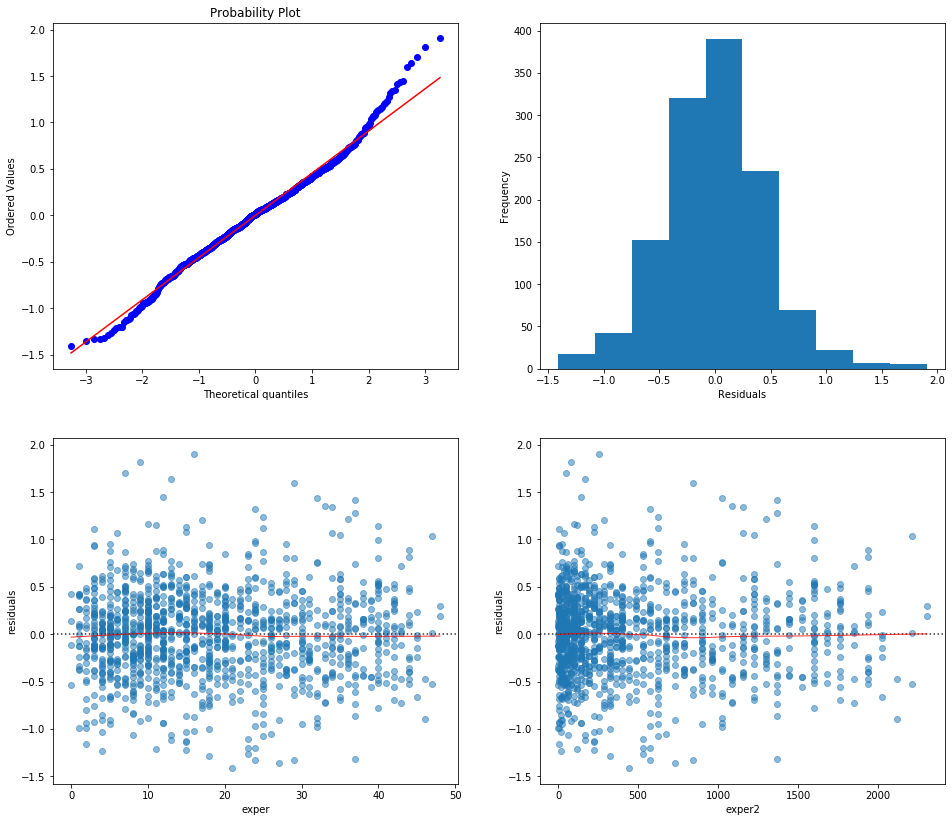

In [129]:
gridsize = (2, 2)
fig = plt.figure(figsize=(16, 14))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))
st.probplot(model2.resid, plot=ax1)

model2.resid.plot.hist(ax=ax2)
ax2.set_xlabel('Residuals')

sns.residplot(features['exper'], 
              model2.resid,
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
              ax=ax3)
ax3.set_ylabel('residuals')
sns.residplot(features['exper2'], 
              model2.resid,
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
              ax=ax4)
_ = ax4.set_ylabel('residuals')

Квадратичная зависимость ушла

### Проверка гипотез по остаткам

In [130]:
print(f'Нормальность ошибок: {st.shapiro(model2.resid)}')
print(f'Равенство распределений: {st.wilcoxon(model2.resid)}')
print(f'Гомоскедастичность: {het_breuschpagan(model2.resid, features)}')

Нормальность ошибок: (0.9899681210517883, 1.4064468700780708e-07)
Равенство распределений: WilcoxonResult(statistic=395967.0, pvalue=0.9618006539573611)
Гомоскедастичность: (328.7332410972614, 1.2887239540138493e-64, 40.09202746154309, 1.768759927540039e-74)


Остатки всё еще ненормальны и гетероскедастичны

Незначимые признаки: `goodhlth`, `black`, `married`, `above_avg`. Прежде, чем удалять лишние признаки, проверим, не входят ли они в значимые попарные взаимодействия:



In [131]:
formula = [formula2]
formula

['log_wage ~ exper + union + goodhlth + black + female + married + service + educ + below_avg + above_avg + exper2']

In [132]:
for f1 in range(len(feat_names)):
    for f2 in range(f1 + 1, len(feat_names)):
        formula.append(feat_names[f1] + ':' + feat_names[f2])
formula = ' + '.join(formula)
formula

'log_wage ~ exper + union + goodhlth + black + female + married + service + educ + below_avg + above_avg + exper2 + exper:union + exper:goodhlth + exper:black + exper:female + exper:married + exper:service + exper:educ + exper:below_avg + exper:above_avg + exper:exper2 + union:goodhlth + union:black + union:female + union:married + union:service + union:educ + union:below_avg + union:above_avg + union:exper2 + goodhlth:black + goodhlth:female + goodhlth:married + goodhlth:service + goodhlth:educ + goodhlth:below_avg + goodhlth:above_avg + goodhlth:exper2 + black:female + black:married + black:service + black:educ + black:below_avg + black:above_avg + black:exper2 + female:married + female:service + female:educ + female:below_avg + female:above_avg + female:exper2 + married:service + married:educ + married:below_avg + married:above_avg + married:exper2 + service:educ + service:below_avg + service:above_avg + service:exper2 + educ:below_avg + educ:above_avg + educ:exper2 + below_avg:abov

In [133]:
model_all = sm.OLS.from_formula(formula, data2).fit()

anova = sm.stats.anova_lm(model_all)
bad_names = []
for id, p in enumerate(anova['PR(>F)']):
    if p < 0.05:
        print(anova.iloc[id].name, p)
    else:
        bad_names.append(anova.iloc[id].name)

exper 1.0242732915841127e-43
union 2.882244947315734e-11
goodhlth 0.00012429806605436422
black 2.123758410300515e-09
female 3.0573484873907394e-54
educ 2.8718827125145426e-49
below_avg 0.0009844887137852496
exper2 1.7723440240433156e-10
exper:female 0.00043843490464056534
goodhlth:black 0.02851736558720818
black:female 0.0010256046604487817
black:exper2 0.04377330314912707
female:married 0.01038359283104283
educ:exper2 0.028306009514270276


Визуальный анализ остатков не показывает никаких существенных особенностей: 

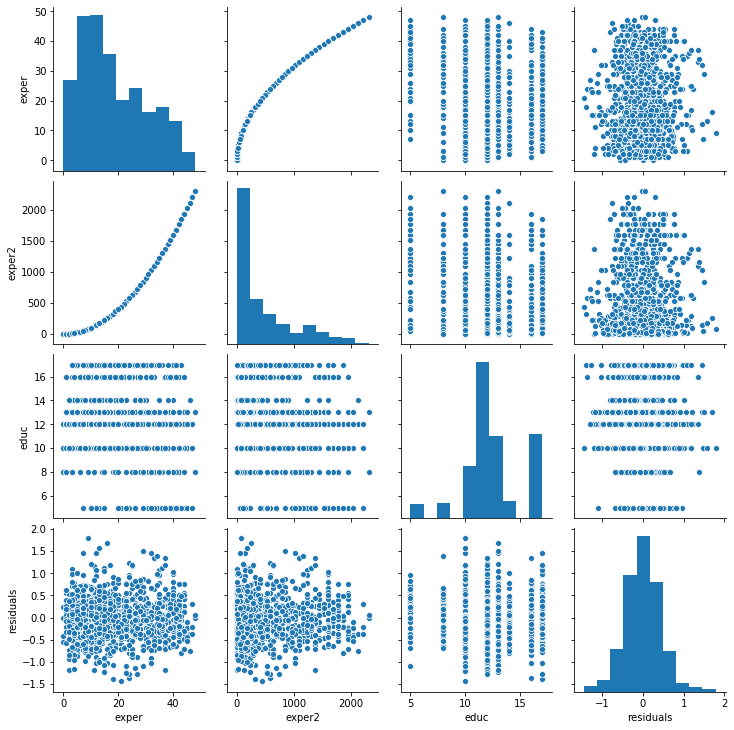

In [134]:
_ = sns.pairplot(pd.DataFrame({
    'exper': features['exper'], 
    'exper2': features['exper2'],
    'educ': features['educ'], 
    'residuals': model_all.resid
}))

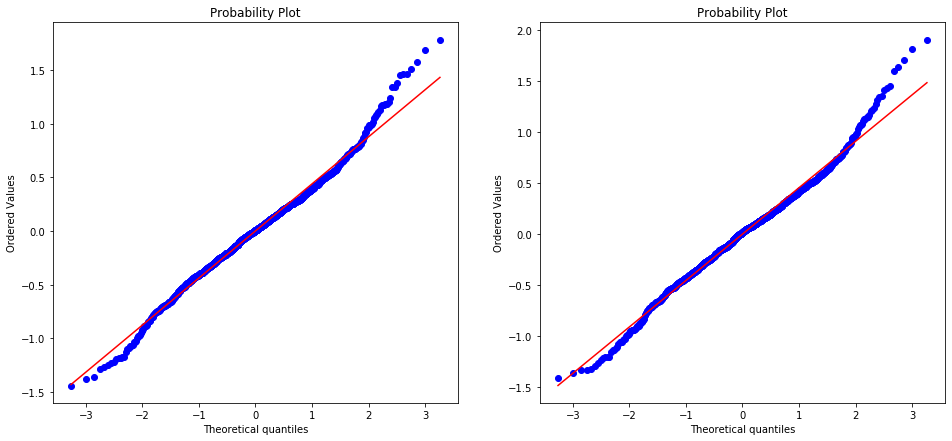

In [135]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
_ = st.probplot(model_all.resid, plot=plt)

plt.subplot(122)
_ = st.probplot(model2.resid, plot=plt)

# Модель 3
Удалим из модели 2 незначимые признаки (`goodhlth`, `black`, `married`) и добавим межфакторное взаимодействие пола и опыта работы, при этом оставим `above_avg`, так как мы хотим оценить влияние внешней привлекательности на зарплату

In [136]:
bad_feats = ['goodhlth', 'black', 'married']
formula3 = ' '.join(['log_wage ~', 
                    ' + '.join([f for f in features if f not in bad_feats] + ['exper:female'])])
print(formula3)

log_wage ~ exper + union + female + service + educ + below_avg + above_avg + exper2 + exper:female


In [137]:
model3 = sm.OLS.from_formula(formula3, data=data2).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     95.00
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          8.39e-135
Time:                        19:31:34   Log-Likelihood:                -793.10
No. Observations:                1259   AIC:                             1606.
Df Residuals:                    1249   BIC:                             1658.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3126      0.082      3.801      0.000       0.151       0.474
exper            0.0468      0.005     10.328      0.000       0.038       0.056
union            0.1719      0.029      5.846      0.000       0.114       0.230
female          -0.2607      0.050     -5.189      0.000      -0.359      -0.162
service         -0.1607      0.032     -5.071      0.000      -0.223      -0.099
educ             0.0776      0.005     14.496      0.000       0.067       0.088
below_avg       -0.1337      0.041     -3.292      0.001      -0.213      -0.054
above_avg       -0.0037      0.029     -0.125      0.900      -0.061       0.054
exper2          -0.0007   9.68e-05     -7.297      0.000      -0.001      -0.001
exper:female    -0.0089      0.003     -3.515      0.000      -0.014      -0.004
==============================================================================
Omnibus:                       29.099   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.989
Skew:                           0.136   Prob(JB):                     1.89e-12
Kurtosis:                       3.977   Cond. No.                     4.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Проверка гипотез по остаткам

In [139]:
print(st.shapiro(model3.resid))
print(st.wilcoxon(model3.resid))

(0.990532636642456, 3.006317399467662e-07)
WilcoxonResult(statistic=396206.0, pvalue=0.9765679529827171)


In [141]:
print(st.shapiro(model2.resid))
print(st.wilcoxon(model2.resid))

(0.9899681210517883, 1.4064468700780708e-07)
WilcoxonResult(statistic=395967.0, pvalue=0.9618006539573611)


Значимы все признаки, кроме индикатора привлекательности выше среднего.

Визуальный анализ остатков не показывает никаких существенных особенностей: 

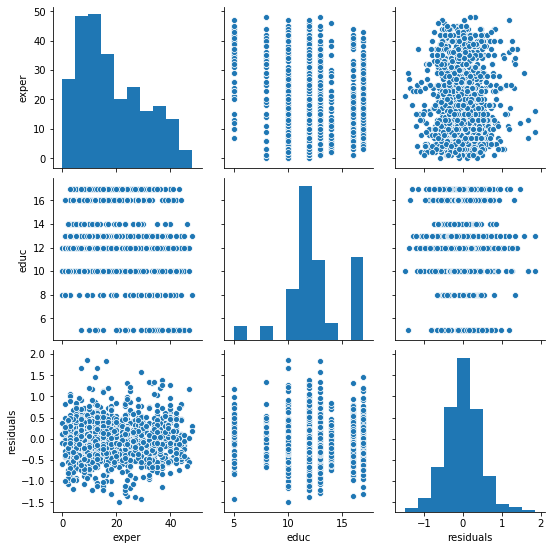

In [142]:
_ = sns.pairplot(pd.DataFrame({
    'exper': features['exper'], 
    'educ': features['educ'], 
    'residuals': model3.resid
}))

((array([-3.26340922, -3.0031529 , -2.85823234, ...,  2.85823234,
          3.0031529 ,  3.26340922]),
  array([-1.48289062, -1.41543858, -1.37135339, ...,  1.68225965,
          1.84339205,  1.85005325])),
 (0.4530900150335955, 1.2272234975729136e-14, 0.9950698507614597))

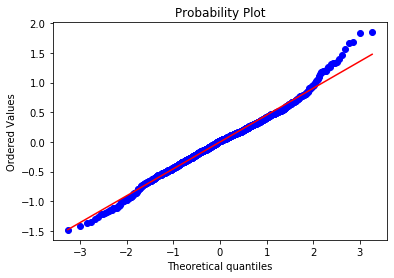

In [143]:
st.probplot(model3.resid, plot=plt)

In [144]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          1.18e-123
Time:                        19:33:41   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.095      4.737      0.000       0.265       0.639
exper          0.0138      0.001     11.546      0.000       0.011       0.016
union          0.1785      0.030      5.957      0.000       0.120       0.237
goodhlth       0.0785      0.053      1.470      0.142      -0.026       0.183
black         -0.0989      0.052     -1.913      0.056      -0.200       0.003
female        -0.3938      0.031    -12.684      0.000      -0.455      -0.333
married        0.0425      0.031      1.383      0.167      -0.018       0.103
service       -0.1505      0.032     -4.656      0.000      -0.214      -0.087
educ           0.0799      0.005     14.581      0.000       0.069       0.091
below_avg     -0.1305      0.041     -3.148      0.002      -0.212      -0.049
above_avg     -0.0041      0.030     -0.138      0.890      -0.063       0.055
==============================================================================
Omnibus:                       27.318   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.550
Skew:                           0.159   Prob(JB):                     7.80e-11
Kurtosis:                       3.887   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          3.19e-131
Time:                        19:33:41   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3424      0.095      3.588      0.000       0.155       0.530
exper          0.0404      0.004      9.290      0.000       0.032       0.049
union          0.1710      0.030      5.793      0.000       0.113       0.229
goodhlth       0.0716      0.053      1.361      0.174      -0.032       0.175
black         -0.0831      0.051     -1.631      0.103      -0.183       0.017
female        -0.3936      0.031    -12.875      0.000      -0.454      -0.334
married        0.0101      0.031      0.329      0.742      -0.050       0.070
service       -0.1599      0.032     -5.018      0.000      -0.222      -0.097
educ           0.0758      0.005     13.941      0.000       0.065       0.086
below_avg     -0.1352      0.041     -3.313      0.001      -0.215      -0.055
above_avg     -0.0025      0.030     -0.084      0.933      -0.061       0.056
exper2        -0.0006   9.63e-05     -6.351      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       30.019   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.257
Skew:                           0.140   Prob(JB):                     6.08e-13
Kurtosis:                       3.997   Cond. No.                     5.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
model2.compare_lr_test(model3)

(-7.522904152245701, 1.0, 2.0)

In [147]:
model2.compare_f_test(model3)

(-3.714491614275083, 1.0, 2.0)

# Модель 4
Попробуем оставить в модели 2 цвет кожи и семейное положение, чтобы добавить их взаимодействия с полом. Как и в модели 3, добавим взаимодействие пола с опытом работы, а состояние здоровья удалим.

In [148]:
features.columns

Index(['exper', 'union', 'goodhlth', 'black', 'female', 'married', 'service',
       'educ', 'below_avg', 'above_avg', 'exper2'],
      dtype='object')

In [149]:
bad_feats = ['goodhlth']
add_feats = ['exper:female', 'black:female', 'married:female']
formula4 = ' '.join(['log_wage ~', 
                    ' + '.join([f for f in features if f not in bad_feats] + add_feats)])
print(formula4)

log_wage ~ exper + union + black + female + married + service + educ + below_avg + above_avg + exper2 + exper:female + black:female + married:female


In [151]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     95.00
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          8.39e-135
Time:                        19:36:42   Log-Likelihood:                -793.10
No. Observations:                1259   AIC:                             1606.
Df Residuals:                    1249   BIC:                             1658.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3126      0.082      3.801      0.000       0.151       0.474
exper            0.0468      0.005     10.328      0.000       0.038       0.056
union            0.1719      0.029      5.846      0.000       0.114       0.230
female          -0.2607      0.050     -5.189      0.000      -0.359      -0.162
service         -0.1607      0.032     -5.071      0.000      -0.223      -0.099
educ             0.0776      0.005     14.496      0.000       0.067       0.088
below_avg       -0.1337      0.041     -3.292      0.001      -0.213      -0.054
above_avg       -0.0037      0.029     -0.125      0.900      -0.061       0.054
exper2          -0.0007   9.68e-05     -7.297      0.000      -0.001      -0.001
exper:female    -0.0089      0.003     -3.515      0.000      -0.014      -0.004
==============================================================================
Omnibus:                       29.099   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.989
Skew:                           0.136   Prob(JB):                     1.89e-12
Kurtosis:                       3.977   Cond. No.                     4.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
model4 = sm.OLS.from_formula(formula4, data=data2).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     68.56
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          7.41e-136
Time:                        19:36:33   Log-Likelihood:                -781.49
No. Observations:                1259   AIC:                             1591.
Df Residuals:                    1245   BIC:                             1663.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3146      0.086      3.676      0.000       0.147       0.482
exper              0.0447      0.005      9.544      0.000       0.036       0.054
union              0.1782      0.029      6.095      0.000       0.121       0.236
black             -0.2508      0.073     -3.456      0.001      -0.393      -0.108
female            -0.1954      0.060     -3.266      0.001      -0.313      -0.078
married            0.0703      0.042      1.661      0.097      -0.013       0.153
service           -0.1603      0.031     -5.093      0.000      -0.222      -0.099
educ               0.0757      0.005     14.101      0.000       0.065       0.086
below_avg         -0.1353      0.040     -3.348      0.001      -0.215      -0.056
above_avg         -0.0011      0.029     -0.036      0.971      -0.058       0.056
exper2            -0.0007   9.85e-05     -6.842      0.000      -0.001      -0.000
exper:female      -0.0082      0.003     -3.175      0.002      -0.013      -0.003
black:female       0.3295      0.100      3.301      0.001       0.134       0.525
married:female    -0.1638      0.061     -2.707      0.007      -0.282      -0.045
==============================================================================
Omnibus:                       27.606   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.337
Skew:                           0.140   Prob(JB):                     1.93e-11
Kurtosis:                       3.928   Cond. No.                     6.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Проверка гипотез по остаткам

In [152]:
print(st.shapiro(model4.resid))
print(st.wilcoxon(model4.resid))

(0.9917947053909302, 1.8001228454522789e-06)
WilcoxonResult(statistic=395495.0, pvalue=0.9326800628180342)


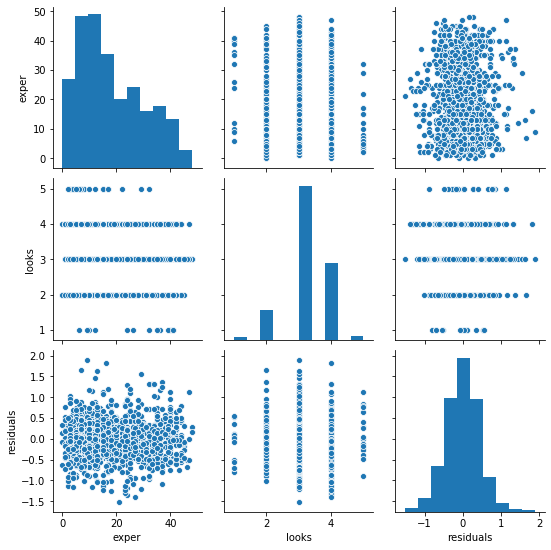

In [153]:
# _ = sns.pairplot(pd.concat([features[[ 'exper', 'educ', 'looks']], model4.resid],axis=1))
_ = sns.pairplot(pd.DataFrame({
    'exper': features['exper'], 
    'looks': looks,
    'residuals': model4.resid
}))

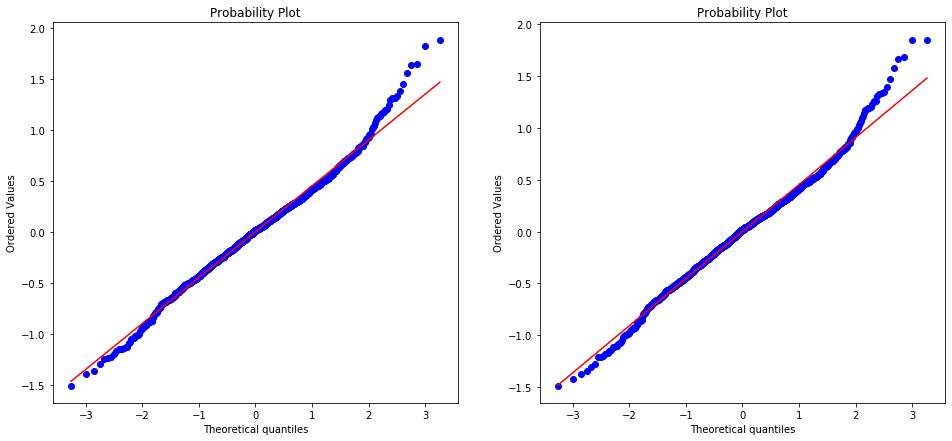

In [154]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
_ = st.probplot(model4.resid, plot=plt)

plt.subplot(122)
_ = st.probplot(model3.resid, plot=plt)

# Модель 5
В предыдущей модели семейное положение незначимо; посмотрим, можно ли удалить его

In [155]:
features.columns

Index(['exper', 'union', 'goodhlth', 'black', 'female', 'married', 'service',
       'educ', 'below_avg', 'above_avg', 'exper2'],
      dtype='object')

In [156]:
bad_feats = ['goodhlth', 'married']
add_feats = ['exper:female', 'black:female', 'married:female']
formula5 = ' '.join(['log_wage ~', 
                    ' + '.join([f for f in features if f not in bad_feats] + add_feats)])
print(formula5)

log_wage ~ exper + union + black + female + service + educ + below_avg + above_avg + exper2 + exper:female + black:female + married:female


In [158]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     68.56
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          7.41e-136
Time:                        19:40:00   Log-Likelihood:                -781.49
No. Observations:                1259   AIC:                             1591.
Df Residuals:                    1245   BIC:                             1663.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3146      0.086      3.676      0.000       0.147       0.482
exper              0.0447      0.005      9.544      0.000       0.036       0.054
union              0.1782      0.029      6.095      0.000       0.121       0.236
black             -0.2508      0.073     -3.456      0.001      -0.393      -0.108
female            -0.1954      0.060     -3.266      0.001      -0.313      -0.078
married            0.0703      0.042      1.661      0.097      -0.013       0.153
service           -0.1603      0.031     -5.093      0.000      -0.222      -0.099
educ               0.0757      0.005     14.101      0.000       0.065       0.086
below_avg         -0.1353      0.040     -3.348      0.001      -0.215      -0.056
above_avg         -0.0011      0.029     -0.036      0.971      -0.058       0.056
exper2            -0.0007   9.85e-05     -6.842      0.000      -0.001      -0.000
exper:female      -0.0082      0.003     -3.175      0.002      -0.013      -0.003
black:female       0.3295      0.100      3.301      0.001       0.134       0.525
married:female    -0.1638      0.061     -2.707      0.007      -0.282      -0.045
==============================================================================
Omnibus:                       27.606   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.337
Skew:                           0.140   Prob(JB):                     1.93e-11
Kurtosis:                       3.928   Cond. No.                     6.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
model5 = sm.OLS.from_formula(formula5, data=data2).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     73.94
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          3.29e-136
Time:                        19:39:49   Log-Likelihood:                -782.88
No. Observations:                1259   AIC:                             1592.
Df Residuals:                    1246   BIC:                             1659.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3500      0.083      4.220      0.000       0.187       0.513
exper              0.0468      0.005     10.335      0.000       0.038       0.056
union              0.1784      0.029      6.098      0.000       0.121       0.236
black             -0.2670      0.072     -3.711      0.000      -0.408      -0.126
female            -0.2348      0.055     -4.271      0.000      -0.343      -0.127
service           -0.1593      0.032     -5.058      0.000      -0.221      -0.098
educ               0.0755      0.005     14.055      0.000       0.065       0.086
below_avg         -0.1382      0.040     -3.421      0.001      -0.218      -0.059
above_avg         -0.0016      0.029     -0.054      0.957      -0.059       0.056
exper2            -0.0007   9.68e-05     -7.272      0.000      -0.001      -0.001
exper:female      -0.0091      0.003     -3.584      0.000      -0.014      -0.004
black:female       0.3463      0.099      3.485      0.001       0.151       0.541
married:female    -0.0946      0.044     -2.154      0.031      -0.181      -0.008
==============================================================================
Omnibus:                       28.254   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.740
Skew:                           0.144   Prob(JB):                     9.59e-12
Kurtosis:                       3.940   Cond. No.                     6.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Проверка гипотез по остаткам

In [159]:
print(st.shapiro(model5.resid))
print(st.wilcoxon(model5.resid))

(0.9914088845252991, 1.0268553296555183e-06)
WilcoxonResult(statistic=395184.0, pvalue=0.9135392540174979)


In [160]:
print(st.shapiro(model4.resid))
print(st.wilcoxon(model4.resid))

(0.9917947053909302, 1.8001228454522789e-06)
WilcoxonResult(statistic=395495.0, pvalue=0.9326800628180342)


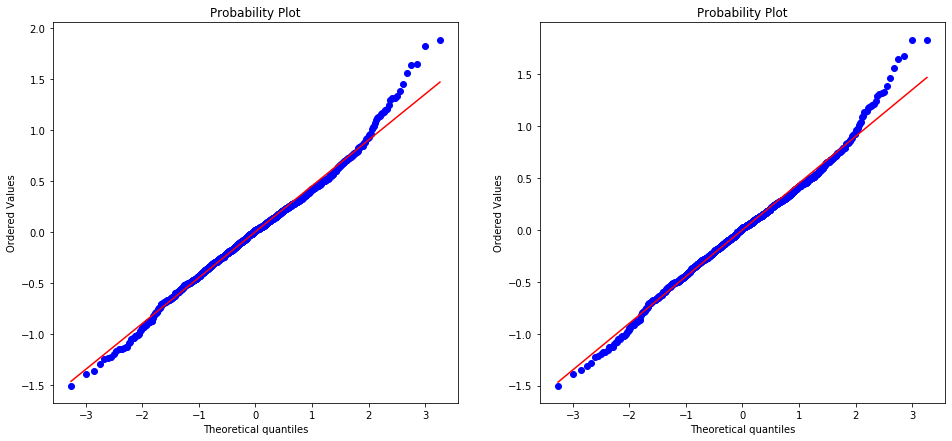

In [161]:
plt.figure(figsize=(16, 7))
plt.subplot(121)
_ = st.probplot(model4.resid, plot=plt)

plt.subplot(122)
_ = st.probplot(model5.resid, plot=plt)

Стоит вернуться к модели 4

# Расстояние Кука
Посмотрим на влиятельные наблюдения: 
    

In [162]:
cook = model4.get_influence().summary_frame().loc[:,'cooks_d']

(-0.01, 0.05)

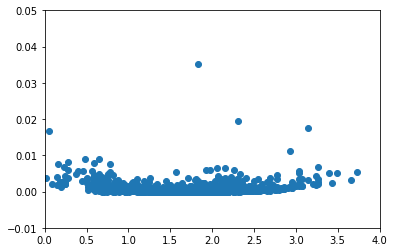

In [163]:
plt.scatter(data2['log_wage'], cook)
plt.xlim((0,4))
plt.ylim((-0.01, 0.05))

Удалим наблюдения с расстоянием Кука больше 0.015 (порог выбран визуально) и перенастроим модель 4.

Сравним коэффициенты новой модели и модели 4:

In [164]:
data3 = data2[cook < 0.015]
data3.shape

(1255, 13)

In [166]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     68.56
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          7.41e-136
Time:                        19:44:42   Log-Likelihood:                -781.49
No. Observations:                1259   AIC:                             1591.
Df Residuals:                    1245   BIC:                             1663.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3146      0.086      3.676      0.000       0.147       0.482
exper              0.0447      0.005      9.544      0.000       0.036       0.054
union              0.1782      0.029      6.095      0.000       0.121       0.236
black             -0.2508      0.073     -3.456      0.001      -0.393      -0.108
female            -0.1954      0.060     -3.266      0.001      -0.313      -0.078
married            0.0703      0.042      1.661      0.097      -0.013       0.153
service           -0.1603      0.031     -5.093      0.000      -0.222      -0.099
educ               0.0757      0.005     14.101      0.000       0.065       0.086
below_avg         -0.1353      0.040     -3.348      0.001      -0.215      -0.056
above_avg         -0.0011      0.029     -0.036      0.971      -0.058       0.056
exper2            -0.0007   9.85e-05     -6.842      0.000      -0.001      -0.000
exper:female      -0.0082      0.003     -3.175      0.002      -0.013      -0.003
black:female       0.3295      0.100      3.301      0.001       0.134       0.525
married:female    -0.1638      0.061     -2.707      0.007      -0.282      -0.045
==============================================================================
Omnibus:                       27.606   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.337
Skew:                           0.140   Prob(JB):                     1.93e-11
Kurtosis:                       3.928   Cond. No.                     6.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
model6 = sm.OLS.from_formula(formula4, data=data3).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_wage   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     71.54
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          1.50e-140
Time:                        19:44:23   Log-Likelihood:                -761.27
No. Observations:                1255   AIC:                             1551.
Df Residuals:                    1241   BIC:                             1622.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2654      0.085      3.119      0.002       0.098       0.432
exper              0.0474      0.005     10.154      0.000       0.038       0.057
union              0.1805      0.029      6.257      0.000       0.124       0.237
black             -0.2120      0.072     -2.931      0.003      -0.354      -0.070
female            -0.1484      0.060     -2.489      0.013      -0.265      -0.031
married            0.0813      0.042      1.942      0.052      -0.001       0.163
service           -0.1721      0.031     -5.526      0.000      -0.233      -0.111
educ               0.0770      0.005     14.472      0.000       0.067       0.087
below_avg         -0.1310      0.040     -3.285      0.001      -0.209      -0.053
above_avg         -0.0042      0.029     -0.146      0.884      -0.061       0.053
exper2            -0.0007   9.81e-05     -7.429      0.000      -0.001      -0.001
exper:female      -0.0102      0.003     -3.925      0.000      -0.015      -0.005
black:female       0.2440      0.100      2.441      0.015       0.048       0.440
married:female    -0.1793      0.060     -2.999      0.003      -0.297      -0.062
==============================================================================
Omnibus:                       20.208   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.057
Skew:                           0.091   Prob(JB):                     4.02e-08
Kurtosis:                       3.786   Cond. No.                     6.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
st.shapiro(model6.resid)

(0.9936299920082092, 3.2664454920450225e-05)

In [171]:
st.shapiro(model4.resid)

(0.9917947053909302, 1.8001228454522789e-06)

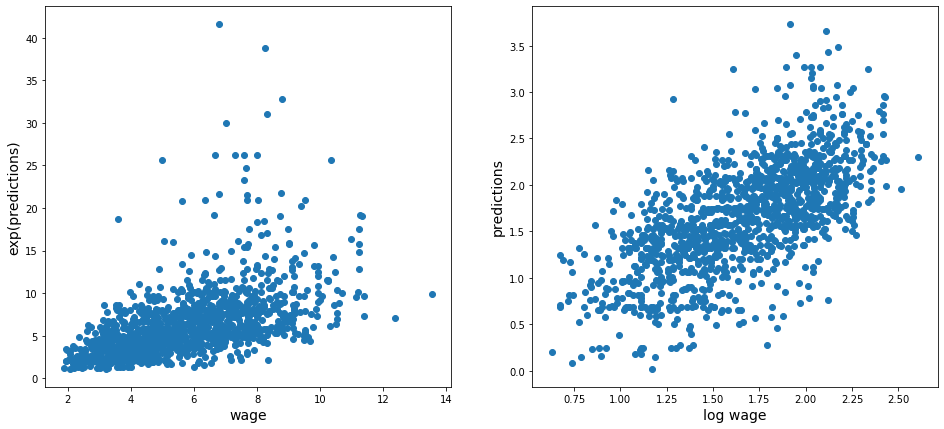

In [167]:
plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(np.exp(model6.predict(data3)), data3['wage'])
plt.xlabel('wage', fontsize=14)
plt.ylabel('exp(predictions)', fontsize=14)

plt.subplot(122)
plt.scatter(model6.predict(data3), data3['log_wage'])
plt.xlabel('log wage', fontsize=14)
_ = plt.ylabel('predictions', fontsize=14)

## Итого

- Итоговая модель (№6) объясняет 43% вариации логарифма отклика
- Коэффициент при `below_avg`: -0.13 => человек, привлекательность которого ниже среднего, получает зарплату на 13% ниже, в среднем ($p=0.001$, 95%-й доверительный интервал: \[5,21\]%)
- Коэффициент при `above_avg`: -0.042 => человек, привлекательность которого выше среднего, примерно такую же, сколько и люди со средним уровнем привлекательности ($p =  0.884$, 95%-й доверительный интервал: \[-6, 6\]%), признак неинформативен